In [27]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold , cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import warnings

In [28]:
seed = 42
rng = np.random.default_rng(seed)

def make_data(d , n = 1500 , seed = 42):
    X , y = make_classification(
        n_samples = n , n_features = d , n_informative = 5 ,
        n_redundant = 0 , n_clusters_per_class = 2 , class_sep = 1.0 ,
        flip_y = 0.03 , random_state = seed
    )
    return X , y

d = 200
X , y = make_data(d = d , n = 1500 , seed = seed)
cv = StratifiedKFold(n_splits = 5 , shuffle = True , random_state = seed)

def cv_score(C , l1_ratio):
    pipe = Pipeline([
        ("scaler" , StandardScaler()) ,
        ("clf" , LogisticRegression(
            C = C , l1_ratio = l1_ratio , solver = "saga" , max_iter = 4000
        ))
    ])
    return cross_val_score(pipe , X , y , cv = cv , scoring = "accuracy").mean()

budget = 50 # 50 points

In [29]:
#==============================
# Grid search (fixed spacing)
#==============================
grid_C = np.linspace(1e-4 , 1e4 , 25)
grid_l1 = np.array([0.0 , 1.0])
grid_params = [(C , l1) for C in grid_C for l1 in grid_l1]
grid_scores = np.array([cv_score(C , l1) for C , l1 in grid_params])

#==============================
# Random search (log-uniform)
#==============================
rand_logC = rng.uniform(-4 , 4 , size = budget)
rand_C = 10 ** rand_logC
rand_l1 = rng.uniform(0.0 , 1.0 , size = budget)
rand_params = list(zip(rand_C , rand_l1))
rand_scores = np.array([cv_score(C , l1) for C , l1 in rand_params])

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Best-so-far CV Accuracy vs Trials (2D tuning)')

Text(0.5, 0, 'Trial')

Text(0, 0.5, 'Best 5-Fold CV Accuracy so far')

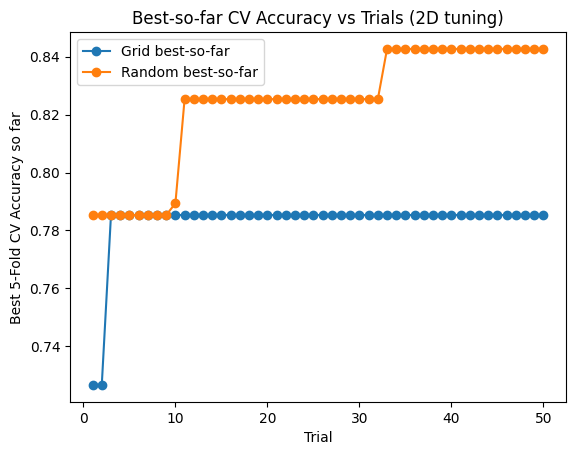

In [30]:
#==========================
# Plot: best-so-far curves
#==========================
grid_best = np.maximum.accumulate(grid_scores)
rand_best = np.maximum.accumulate(rand_scores)

plt.figure()
plt.plot(np.arange(1 , budget + 1) , grid_best , marker = "o" , label = "Grid best-so-far")
plt.plot(np.arange(1 , budget + 1) , rand_best , marker = "o" , label = "Random best-so-far")
plt.title("Best-so-far CV Accuracy vs Trials (2D tuning)")
plt.xlabel("Trial")
plt.ylabel("Best 5-Fold CV Accuracy so far")
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Grid trials: (log10(C) , l1_ratio) -> CV Accuracy')

Text(0.5, 0, 'log10(C)')

Text(0, 0.5, 'l1_ratio')

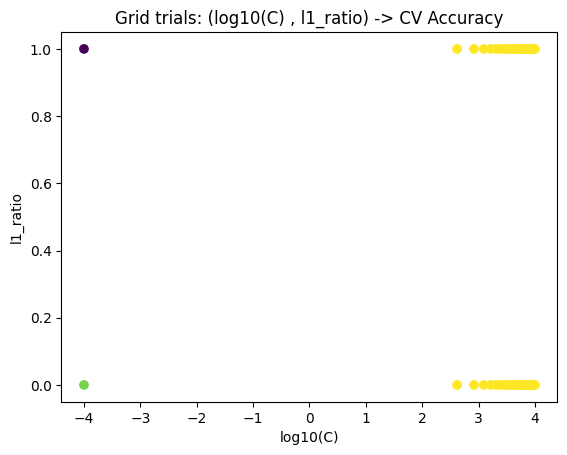

In [31]:
#==================================================
# Plot: explored search space (log10(C) , l1_ratio)
#==================================================
plt.figure()
gx = np.log10([p[0] for p in grid_params])
gy = [p[1] for p in grid_params]
plt.scatter(gx , gy , c = grid_scores)
plt.title("Grid trials: (log10(C) , l1_ratio) -> CV Accuracy")
plt.xlabel("log10(C)")
plt.ylabel("l1_ratio")
plt.show()

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Random trials (log-uniform): (log10(C) , l1_ratio) -> CV Accuracy')

Text(0.5, 0, 'log10(C)')

Text(0, 0.5, 'l1_ratio')

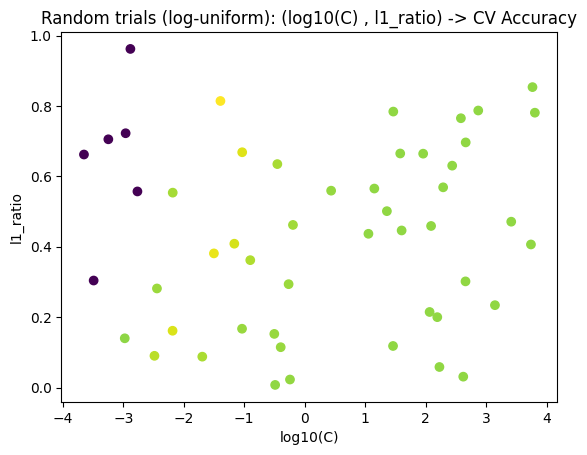

In [32]:
#==================================================
# Plot: explored search space (log10(C) , l1_ratio)
#==================================================
plt.figure()
rx = np.log10([p[0] for p in rand_params])
ry = [p[1] for p in rand_params]
plt.scatter(rx , ry , c = rand_scores)
plt.title("Random trials (log-uniform): (log10(C) , l1_ratio) -> CV Accuracy")
plt.xlabel("log10(C)")
plt.ylabel("l1_ratio")
plt.show()

In [33]:
#=========
# Outputs
#=========
best_g = int(np.argmax(grid_scores))
best_r = int(np.argmax(rand_scores))

print("Best Grid Search: ")
print("  C =" , round(grid_params[best_g][0] , 6) , "| l1_ratio =" , round(grid_params[best_g][1] , 3) , "| CV Acc =" , round(grid_scores[best_g] , 3))

print("Best Random Search: ")
print("  C =" , round(rand_params[best_r][0] , 6) , "| l1_ratio =" , round(rand_params[best_r][1] , 3) , "| CV Acc =" , round(rand_scores[best_r] , 3))

print("Random - Grid best CV gap: " , round(rand_scores[best_r] - grid_scores[best_g] , 3))

Best Grid Search: 
  C = 416.666762 | l1_ratio = 0.0 | CV Acc = 0.785
Best Random Search: 
  C = 0.040421 | l1_ratio = 0.814 | CV Acc = 0.843
Random - Grid best CV gap:  0.057
